In [6]:
#importing all libraries

import pandas as pd
import numpy as np
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from keras.models import Sequential
#from sklearn.feature_extraction.text import CountVectorizer    #Convert a collection of text documents to a matrix of token counts
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping

In [7]:
# importing training data

path = r'C:\Users\Jatin Mittal\Downloads\python codes for deep learning\RNN\uci-news-aggregator\uci-news-aggregator.csv'

train_data = pd.read_csv(path)
train_data.head()

,ID,TITLE,URL,PUBLISHER,CATEGORY,STORY,HOSTNAME,TIMESTAMP
0,1,"Fed official says weak data caused by weather,...",http://www.latimes.com/business/money/la-fi-mo...,Los Angeles Times,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.latimes.com,1394470370698
1,2,Fed's Charles Plosser sees high bar for change...,http://www.livemint.com/Politics/H2EvwJSK2VE6O...,Livemint,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.livemint.com,1394470371207
2,3,US open: Stocks fall after Fed official hints ...,http://www.ifamagazine.com/news/us-open-stocks...,IFA Magazine,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.ifamagazine.com,1394470371550
3,4,"Fed risks falling 'behind the curve', Charles ...",http://www.ifamagazine.com/news/fed-risks-fall...,IFA Magazine,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.ifamagazine.com,1394470371793
4,5,Fed's Plosser: Nasty Weather Has Curbed Job Gr...,http://www.moneynews.com/Economy/federal-reser...,Moneynews,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.moneynews.com,1394470372027


In [8]:
# counting different value counts of each category
train_data.CATEGORY.value_counts()

e    152469
b    115967
t    108344
m     45639
Name: CATEGORY, dtype: int64

In [9]:
# balancing classes by taking random 45000 examples of each classes then shuffling entire data

num_of_cat = 45000
shuffled_data = train_data.reindex(np.random.permutation(train_data.index))
e = shuffled_data[shuffled_data["CATEGORY"]=="e"][:num_of_cat]
b = shuffled_data[shuffled_data["CATEGORY"]=="b"][:num_of_cat]
t = shuffled_data[shuffled_data["CATEGORY"]=="t"][:num_of_cat]
m = shuffled_data[shuffled_data["CATEGORY"]=="m"][:num_of_cat]
train_data_bal = pd.concat([e,b,t,m], ignore_index = True)
shuffled_data_bal = train_data_bal.reindex(np.random.permutation(train_data_bal.index))
shuffled_data_bal['Label'] = 0

In [10]:
# making y: target class
label_data = shuffled_data_bal["CATEGORY"]

In [11]:
# one hot encoding of target variable
labels = pd.get_dummies(label_data, columns = ["CATEGORY"], prefix = 'category')
labels.head()

X = shuffled_data_bal['TITLE']

# now we will edit title section such that it contains only n most common words and filters out all puncuations
n_most_common_words = 8000

# our input text data contains headlines of news which are generally small so making max_len=20
max_len = 20

In [12]:
#import nltk
#nltk.download('punkt')
#nltk.download('stopwords')

In [16]:
# preprocessing text for word2vec: to filter punctuatoins, lowering all words, filter stop words
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string

review_lines = list()
lines = X.values.tolist()

for line in lines:
    tokens = word_tokenize(line)  # breaks line into it's sub parts like each word and comma etc, # https://pythonspot.com/tokenizing-words-and-sentences-with-nltk/
    
    
    #convert to lower case
    tokens = [w.lower() for w in tokens]
    
    
    #remove punctuation from each word
    # brief detail: https://pythonadventures.wordpress.com/2017/02/05/remove-punctuations-from-a-text/
    
    table = str.maketrans('','', string.punctuation)
    stripped = [w.translate(table) for w in tokens]
    
    # remove remaining tokens that are not alphabetic
    words = [word for word in stripped if word.isalpha()]
    
    
    # filter out stop words
    stop_words = set(stopwords.words('english'))
    words = [w for w in words if not w in stop_words]
    review_lines.append(words)

In [17]:
# training word2vec on preprecessed text data
import gensim

# detail: https://towardsdatascience.com/machine-learning-word-embedding-sentiment-classification-using-keras-b83c28087456
# size is size of the embedding vector

embedding_vector_size = 50
model = gensim.models.Word2Vec(sentences = review_lines, size=embedding_vector_size, min_count=1, window=5, workers=4 )

# to get total number of unique words
words = list(model.wv.vocab)

print("vocab size:", len(words))

vocab size: 42368


In [18]:
#  converting preprocessed text data to numeric form to input in our model

tokenizer = Tokenizer()
X = review_lines
tokenizer.fit_on_texts(X)
sequences = tokenizer.texts_to_sequences(X) # gives each word an index based on most occuring and filters top 8000 words 
X = pad_sequences(sequences, maxlen=max_len) # pads 0 in front of each example

In [19]:
# preparing embedding matrix for embedding layer

'''
# to get vector of a given word
model.wv['gigafactory']

# to get list of all unique words
# print(words)
'''


# create a weight matrix for all unique words in training set
vocab_size = len(tokenizer.word_index) + 1
embedding_matrix = np.zeros((vocab_size, embedding_vector_size))
for word, i in tokenizer.word_index.items():
	embedding_vector = model.wv[word]
	if embedding_vector is not None:
		embedding_matrix[i] = embedding_vector


In [20]:
# splitting training and test data

X_train, X_test, y_train, y_test = train_test_split(X , labels, test_size=0.25, random_state=42)

In [24]:
# building the RNN model

model2 = Sequential()

# little detail on embeddings: https://www.shanelynn.ie/get-busy-with-word-embeddings-introduction/

# NOTE: This implementation of embedding is known as EMBEDDING using word2Vec. There is another implementation where we use in-built
# embeddings. lINK: https://jovianlin.io/embeddings-in-keras/

#NOTE: inpu_dim x output_dim = embedding_matrix.shape
n_most_common_words = 8000
model2.add(Embedding(input_dim = vocab_size, output_dim = embedding_vector_size, input_length = max_len, weights=[embedding_matrix]))
model2.add(SpatialDropout1D(0.7))
model2.add(LSTM(64, dropout=0.7, recurrent_dropout=0.7))
model2.add(Dense(4, activation='softmax'))
model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
print(model2.summary())

history = model2.fit(X_train, y_train, epochs = 6, batch_size = 100, validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss',patience=7, min_delta=0.0001)])

# brief on callbacks(early stopping): https://keras.io/callbacks/#earlystopping

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 20, 50)            2118450   
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, 20, 50)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                29440     
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 260       
Total params: 2,148,150
Trainable params: 2,148,150
Non-trainable params: 0
_________________________________________________________________
None
Train on 108000 samples, validate on 27000 samples
Epoch 1/6
108000/108000 [==============================] - 145s 1ms/step - loss: 1.1057 - acc: 0.5149 - val_loss: 0.5638 - val_acc: 0.7953
Epoch 2/6
108000/108000 [==============================] - 147s 1ms/s

In [25]:
accr = model2.evaluate(X_test,y_test)
print('Test set\n  Loss: {}\n  Accuracy: {}'.format(accr[0],accr[1]))

45000/45000 [==============================] - 7s 155us/step
Test set
  Loss: 0.33570816719532015
  Accuracy: 0.8882666666666666


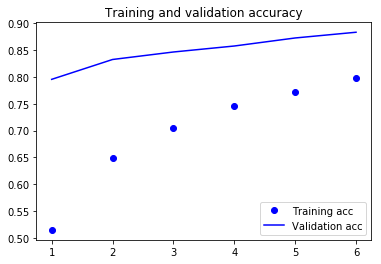

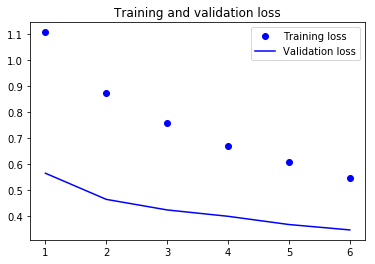

In [27]:
# plotting training and test set accuracy and loss
import matplotlib.pyplot as plt

epochs = range(1,7)
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()